In [ ]:
import requests
from os import listdir, mkdir
from os.path import isdir, isfile, join
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from tqdm import tqdm

In [ ]:
base = 'https://archive.physionet.org/physiobank/database/bidmc/bidmc_csv/'
endings = ['_Breaths.csv','_Numerics.csv','_Signals.csv','_Fix.txt']

files = {}

nums = []
for n in range(1,54):
    if n<10:
        nums.append('0'+str(n))
    else:
        nums.append(str(n))
        
for n in nums:
    files[n] = ['bidmc_'+n+ending for ending in endings]

In [ ]:
csv = {}
txt = {}
for number in tqdm(files.keys()):
    csv[number] = []
    for f in files[number]:
        if 'csv' in f:
            csv[number].append(base+f)
        else:
            txt[number] = f

100%|██████████| 53/53 [00:00<00:00, 69403.09it/s]


In [ ]:
for f in tqdm(files.keys()):
    for n in files[f]:
        if '.txt' not in n:
            df = pd.read_csv(base+n)
            if not isdir("csv"):
                mkdir("csv")
            df.to_csv('csv/'+n)

100%|██████████| 53/53 [03:59<00:00,  4.52s/it]


In [ ]:
for n in tqdm(txt.keys()): 
    text = requests.get(base+txt[n])
    text = text.text
    if not isdir("txt"):
        mkdir("txt")
    with open('txt/'+txt[n], "w") as text_file:
        text_file.write(text)

100%|██████████| 53/53 [00:49<00:00,  1.07it/s]


In [ ]:
def make_dataframe(num):
    signals= pd.read_csv('csv/bidmc_'+str(num)+'_Signals.csv',index_col=0)
    signals['sec'] = signals['Time [s]'].apply(lambda x: int(np.floor(x)))
    numerics = pd.read_csv('csv/bidmc_'+str(num)+'_Numerics.csv',index_col=0)
    numerics.fillna(numerics.mean(),inplace=True) 
    numerics.rename(columns={'Time [s]':'sec'},inplace=True)
    numerics.drop(' RESP',axis=1,inplace=True)
    numerics['sec'] = numerics['sec'].apply(lambda x: int(x))
    signals = signals[[' RESP', ' PLETH', ' V', ' AVR', ' II','sec','Time [s]']]
    person = signals.merge(numerics,on='sec',how='outer')
    Hz_125_cols = [' RESP', ' PLETH', ' V', ' AVR', ' II']
    Min = person[Hz_125_cols+['sec']].groupby('sec').min()
    Min.columns = [i+'_Min' for i in Min.columns]
    Max = person[Hz_125_cols+['sec']].groupby('sec').max()
    Max.columns = [i+'_Max' for i in Max.columns]
    Mean = person[Hz_125_cols+['sec']].groupby('sec').mean()
    Mean.columns = Mean.columns = [i+'_Mean' for i in Mean.columns]
    Kurt = person[Hz_125_cols+['sec']].groupby('sec').agg(lambda x: kurtosis(x))
    Kurt.columns = [i+'_Kurt' for i in Kurt.columns]
    Skw = person[Hz_125_cols+['sec']].groupby('sec').agg(lambda x: skew(x))
    Skw.columns = [i+'_Skw' for i in Skw.columns]
    summary_frames = [Min,Max,Mean,Kurt,Skw]
    one_sec_summary = pd.concat(summary_frames,axis=1).reset_index()
    person = person.merge(one_sec_summary,on='sec',how='outer')
    if not isdir("person_csvs"):
        mkdir("person_csvs")
    person.to_csv('person_csvs/person_'+str(num)+'.csv')

In [ ]:
nums = []
for n in range(1,54):
    if n<10:
        nums.append('0'+str(n))
    else:
        nums.append(str(n))

In [ ]:
for number in nums:
    try:
        make_dataframe(number)
    except:
        print("Ignoring person", number, "due to error")

Ignoring person 09 due to error
Ignoring person 15 due to error
Ignoring person 30 due to error
Ignoring person 38 due to error
Ignoring person 39 due to error
Ignoring person 41 due to error
Ignoring person 47 due to error
Ignoring person 49 due to error


In [ ]:
onlyfiles = [f for f in listdir('person_csvs') if isfile(join('person_csvs', f))]
person_files = ['person_csvs/'+i for i in onlyfiles if 'person' in i]
files = []
for person in tqdm(person_files):
    df = pd.read_csv(person,index_col=0)
    files.append(df)

df = pd.concat(files, axis=0, ignore_index=True)
df.dropna(inplace=True)

print(df.shape)

100%|██████████| 45/45 [00:13<00:00,  3.27it/s]


(2700044, 35)


In [ ]:
df.to_csv('person_csvs/all_people.csv')

In [ ]:
df.head()

,RESP,PLETH,V,AVR,II,sec,Time [s],HR,PULSE,SpO2,...,RESP_Kurt,PLETH_Kurt,V_Kurt,AVR_Kurt,II_Kurt,RESP_Skw,PLETH_Skw,V_Skw,AVR_Skw,II_Skw
0,0.25806,0.59531,0.721570,0.859380,-0.058594,0,0.000,93.0,92.0,96.0,...,-1.400516,-1.087751,10.346496,13.159851,13.949057,-0.242583,0.482318,-3.057577,-3.335702,3.582299
1,0.26393,0.59042,0.696080,0.695310,-0.029297,0,0.008,93.0,92.0,96.0,...,-1.400516,-1.087751,10.346496,13.159851,13.949057,-0.242583,0.482318,-3.057577,-3.335702,3.582299
2,0.26979,0.58358,0.700000,0.455080,0.179690,0,0.016,93.0,92.0,96.0,...,-1.400516,-1.087751,10.346496,13.159851,13.949057,-0.242583,0.482318,-3.057577,-3.335702,3.582299
3,0.27566,0.57771,0.329410,0.041016,0.843750,0,0.024,93.0,92.0,96.0,...,-1.400516,-1.087751,10.346496,13.159851,13.949057,-0.242583,0.482318,-3.057577,-3.335702,3.582299
4,0.28250,0.57283,0.078431,-0.099609,1.318400,0,0.032,93.0,92.0,96.0,...,-1.400516,-1.087751,10.346496,13.159851,13.949057,-0.242583,0.482318,-3.057577,-3.335702,3.582299


In [ ]:
df.skew()

 RESP          4.192024e-01
 PLETH         2.203819e+00
 V            -4.985248e-01
 AVR          -1.050338e+00
 II            5.745610e-01
sec            3.514934e-07
Time [s]      -1.008467e-09
 HR            4.258678e-01
 PULSE         4.590520e-01
 SpO2         -1.613989e+00
 RESP_Min      4.307843e-01
 PLETH_Min     2.087120e+00
 V_Min        -2.401510e-01
 AVR_Min      -1.886430e-01
 II_Min       -5.157483e-01
 RESP_Max     -1.193692e-01
 PLETH_Max     1.745141e+00
 V_Max         6.005654e-01
 AVR_Max       5.855848e-01
 II_Max       -5.038890e-01
 RESP_Mean     1.806233e-01
 PLETH_Mean    1.776977e+00
 V_Mean        5.762518e-02
 AVR_Mean     -9.595049e-01
 II_Mean       2.005228e-01
 RESP_Kurt     1.381080e+01
 PLETH_Kurt    5.244867e+01
 V_Kurt        1.032790e+00
 AVR_Kurt      1.366196e+00
 II_Kurt       1.218775e+00
 RESP_Skw      1.677525e-01
 PLETH_Skw    -5.334396e-02
 V_Skw         1.137635e+00
 AVR_Skw       7.869129e-01
 II_Skw       -1.008688e+00
dtype: float64

In [ ]:
df.kurtosis()

 RESP            -0.450148
 PLETH            4.207069
 V                2.821981
 AVR              2.302539
 II               1.375938
sec              -1.200010
Time [s]         -1.200000
 HR               0.554132
 PULSE            0.488867
 SpO2             3.837332
 RESP_Min         1.176281
 PLETH_Min        4.092246
 V_Min           -1.007683
 AVR_Min         -0.683209
 II_Min          -0.812655
 RESP_Max        -0.742010
 PLETH_Max        1.247532
 V_Max           -0.289003
 AVR_Max          0.828827
 II_Max          -0.018901
 RESP_Mean       -0.436095
 PLETH_Mean       1.467985
 V_Mean          -0.337448
 AVR_Mean         1.307881
 II_Mean          0.116161
 RESP_Kurt      242.807278
 PLETH_Kurt    5064.214479
 V_Kurt           3.728982
 AVR_Kurt         2.573467
 II_Kurt          3.197435
 RESP_Skw        16.033873
 PLETH_Skw       13.255848
 V_Skw            0.727473
 AVR_Skw         -0.173167
 II_Skw           1.241687
dtype: float64

In [ ]:
df.var()

 RESP              0.146377
 PLETH             0.355242
 V                 0.067357
 AVR               0.066318
 II                0.098988
sec            19200.553447
Time [s]       19200.632870
 HR              187.537321
 PULSE           191.342042
 SpO2              9.342812
 RESP_Min          0.071071
 PLETH_Min         0.123409
 V_Min             0.150218
 AVR_Min           0.112223
 II_Min            0.088652
 RESP_Max          0.155801
 PLETH_Max         0.693855
 V_Max             0.072377
 AVR_Max           0.063201
 II_Max            0.111115
 RESP_Mean         0.111193
 PLETH_Mean        0.288203
 V_Mean            0.040514
 AVR_Mean          0.046934
 II_Mean           0.063853
 RESP_Kurt        32.428488
 PLETH_Kurt        0.995905
 V_Kurt           60.522381
 AVR_Kurt         61.223869
 II_Kurt          57.355994
 RESP_Skw          1.292868
 PLETH_Skw         0.191755
 V_Skw             5.152210
 AVR_Skw           4.290816
 II_Skw            3.132465
dtype: float64

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('person_csvs/person_13.csv',index_col=0)
resp = [i for i in data.columns if 'RESP' in i and i!=' RESP']
data.drop(resp+['Time [s]','sec'],axis=1,inplace=True)
data.head()

,RESP,PLETH,V,AVR,II,HR,PULSE,SpO2,PLETH_Min,V_Min,...,AVR_Mean,II_Mean,PLETH_Kurt,V_Kurt,AVR_Kurt,II_Kurt,PLETH_Skw,V_Skw,AVR_Skw,II_Skw
0,0.24438,0.49658,0.56471,0.8,0.031250,66,66,100,0.32845,-0.50196,...,0.762964,0.147906,-0.434146,1.349437,4.023055,0.796755,0.882294,-0.477034,1.359572,0.291865
1,0.24438,0.49071,0.56471,0.8,0.035156,66,66,100,0.32845,-0.50196,...,0.762964,0.147906,-0.434146,1.349437,4.023055,0.796755,0.882294,-0.477034,1.359572,0.291865
2,0.24438,0.48485,0.57059,0.8,0.035156,66,66,100,0.32845,-0.50196,...,0.762964,0.147906,-0.434146,1.349437,4.023055,0.796755,0.882294,-0.477034,1.359572,0.291865
3,0.24438,0.47801,0.57451,0.8,0.035156,66,66,100,0.32845,-0.50196,...,0.762964,0.147906,-0.434146,1.349437,4.023055,0.796755,0.882294,-0.477034,1.359572,0.291865
4,0.24438,0.47116,0.58039,0.8,0.041016,66,66,100,0.32845,-0.50196,...,0.762964,0.147906,-0.434146,1.349437,4.023055,0.796755,0.882294,-0.477034,1.359572,0.291865


In [ ]:
df.mean()

 RESP            0.322684
 PLETH           0.707487
 V               0.659782
 AVR             0.590362
 II              0.370952
sec            239.503919
Time [s]       239.999911
 HR             89.940335
 PULSE          89.390672
 SpO2           96.990535
 RESP_Min        0.103401
 PLETH_Min       0.463537
 V_Min           0.086687
 AVR_Min         0.047195
 II_Min          0.067534
 RESP_Max        0.557117
 PLETH_Max       1.061127
 V_Max           0.894598
 AVR_Max         0.843320
 II_Max          1.082653
 RESP_Mean       0.322684
 PLETH_Mean      0.707487
 V_Mean          0.659782
 AVR_Mean        0.590362
 II_Mean         0.370952
 RESP_Kurt       0.075116
 PLETH_Kurt     -0.842030
 V_Kurt         11.679530
 AVR_Kurt       11.308892
 II_Kurt        10.080501
 RESP_Skw        0.153418
 PLETH_Skw       0.512563
 V_Skw          -2.067256
 AVR_Skw        -1.987537
 II_Skw          2.075529
dtype: float64

In [ ]:
df.median()

 RESP            0.240470
 PLETH           0.485830
 V               0.641180
 AVR             0.625490
 II              0.380390
sec            240.000000
Time [s]       240.000000
 HR             90.000000
 PULSE          89.000000
 SpO2           98.000000
 RESP_Min        0.095797
 PLETH_Min       0.337240
 V_Min           0.160160
 AVR_Min         0.144530
 II_Min          0.119610
 RESP_Max        0.545450
 PLETH_Max       0.711630
 V_Max           0.830080
 AVR_Max         0.786270
 II_Max          1.066700
 RESP_Mean       0.268285
 PLETH_Mean      0.477650
 V_Mean          0.633610
 AVR_Mean        0.609211
 II_Mean         0.390062
 RESP_Kurt      -0.892702
 PLETH_Kurt     -1.005125
 V_Kurt         10.319292
 AVR_Kurt        9.953412
 II_Kurt         8.710419
 RESP_Skw        0.138557
 PLETH_Skw       0.514979
 V_Skw          -2.758062
 AVR_Skw        -2.637218
 II_Skw          2.498663
dtype: float64

In [ ]:
df.quantile(0.25)

 RESP            0.043988
 PLETH           0.385140
 V               0.509780
 AVR             0.474510
 II              0.156250
sec            120.000000
Time [s]       120.000000
 HR             82.000000
 PULSE          81.000000
 SpO2           95.000000
 RESP_Min       -0.000489
 PLETH_Min       0.263930
 V_Min          -0.207840
 AVR_Min        -0.234860
 II_Min         -0.169920
 RESP_Max        0.261000
 PLETH_Max       0.630500
 V_Max           0.689450
 AVR_Max         0.685550
 II_Max          0.825490
 RESP_Mean       0.101577
 PLETH_Mean      0.438264
 V_Mean          0.511202
 AVR_Mean        0.501683
 II_Mean         0.204343
 RESP_Kurt      -1.309480
 PLETH_Kurt     -1.282578
 V_Kurt          6.528733
 AVR_Kurt        5.883146
 II_Kurt         5.067424
 RESP_Skw       -0.382570
 PLETH_Skw       0.239159
 V_Skw          -3.460764
 AVR_Skw        -3.330195
 II_Skw          1.144639
Name: 0.25, dtype: float64

In [ ]:
df.quantile(0.5)

 RESP            0.240470
 PLETH           0.485830
 V               0.641180
 AVR             0.625490
 II              0.380390
sec            240.000000
Time [s]       240.000000
 HR             90.000000
 PULSE          89.000000
 SpO2           98.000000
 RESP_Min        0.095797
 PLETH_Min       0.337240
 V_Min           0.160160
 AVR_Min         0.144530
 II_Min          0.119610
 RESP_Max        0.545450
 PLETH_Max       0.711630
 V_Max           0.830080
 AVR_Max         0.786270
 II_Max          1.066700
 RESP_Mean       0.268285
 PLETH_Mean      0.477650
 V_Mean          0.633610
 AVR_Mean        0.609211
 II_Mean         0.390062
 RESP_Kurt      -0.892702
 PLETH_Kurt     -1.005125
 V_Kurt         10.319292
 AVR_Kurt        9.953412
 II_Kurt         8.710419
 RESP_Skw        0.138557
 PLETH_Skw       0.514979
 V_Skw          -2.758062
 AVR_Skw        -2.637218
 II_Skw          2.498663
Name: 0.5, dtype: float64

In [ ]:
df.quantile(0.75)

 RESP            0.577710
 PLETH           0.659820
 V               0.844730
 AVR             0.745100
 II              0.545100
sec            360.000000
Time [s]       360.000000
 HR             96.000000
 PULSE          95.000000
 SpO2          100.000000
 RESP_Min        0.222870
 PLETH_Min       0.414470
 V_Min           0.394120
 AVR_Min         0.304690
 II_Min          0.319960
 RESP_Max        1.000000
 PLETH_Max       0.773220
 V_Max           1.076500
 AVR_Max         0.990230
 II_Max          1.408200
 RESP_Mean       0.560454
 PLETH_Mean      0.525935
 V_Mean          0.832341
 AVR_Mean        0.721567
 II_Mean         0.512812
 RESP_Kurt      -0.035086
 PLETH_Kurt     -0.578870
 V_Kurt         15.798374
 AVR_Kurt       14.490913
 II_Kurt        13.830726
 RESP_Skw        0.712598
 PLETH_Skw       0.795111
 V_Skw          -1.070467
 AVR_Skw        -0.847557
 II_Skw          3.202370
Name: 0.75, dtype: float64

In [ ]:
df.std()

 RESP            0.382592
 PLETH           0.596022
 V               0.259533
 AVR             0.257524
 II              0.314624
sec            138.566062
Time [s]       138.566348
 HR             13.694427
 PULSE          13.832644
 SpO2            3.056601
 RESP_Min        0.266592
 PLETH_Min       0.351296
 V_Min           0.387580
 AVR_Min         0.334997
 II_Min          0.297745
 RESP_Max        0.394716
 PLETH_Max       0.832980
 V_Max           0.269029
 AVR_Max         0.251398
 II_Max          0.333339
 RESP_Mean       0.333456
 PLETH_Mean      0.536846
 V_Mean          0.201281
 AVR_Mean        0.216643
 II_Mean         0.252691
 RESP_Kurt       5.694602
 PLETH_Kurt      0.997950
 V_Kurt          7.779613
 AVR_Kurt        7.824568
 II_Kurt         7.573374
 RESP_Skw        1.137043
 PLETH_Skw       0.437898
 V_Skw           2.269848
 AVR_Skw         2.071428
 II_Skw          1.769877
dtype: float64

In [ ]:
df.corr()

AttributeError: ignored

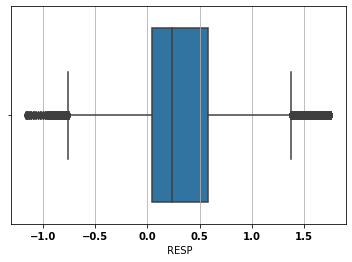

In [ ]:
import seaborn as sns
plt.xticks(weight="bold")
plt.yticks(weight="bold")
plt.grid()
sns.boxplot(df[' RESP']).set_fontsize('18')

plt.show()

In [ ]:
plt.xticks(weight="bold")
plt.yticks(weight="bold")
plt.grid()

sns.distplot(df[' RESP'],hist=None)
plt.show()

In [ ]:
plt.xticks(weight="bold")
plt.yticks(weight="bold")
plt.grid()
sns.histplot(df[' RESP'])
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
X = data.drop(' RESP',axis=1)
SS.fit(X,y=None)
y = data[' RESP'].values
X = SS.transform(X)

In [ ]:
pip install catboost

In [ ]:
import time
import numpy as np
from xgboost import XGBRegressor
import catboost
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.linear_model import Lasso,Ridge,ElasticNet, BayesianRidge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

models = {'DT':DecisionTreeRegressor(),'ElasticNet':ElasticNet(),
         'KNN':neighbors.KNeighborsRegressor(),
         'rff':RandomForestRegressor(), 'xgb':XGBRegressor(),"CB":CatBoostRegressor()}




def model_performance(X,y):
    times =[]
    keys = []
    mean_squared_errors = []
    mean_abs_error = []
    R2_scores = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=10)

    for k,v in models.items():
        model = v
        t0=time.time()
        model.fit(X_train, y_train)
        train_time = time.time()-t0
        t1 = time.time()
        pred = model.predict(X_test)
        predict_time = time.time()-t1
        pred = pd.Series(pred)
        Time_total = train_time+predict_time
        times.append(Time_total)
        R2_scores.append(r2_score(y_test,pred))
        mean_squared_errors.append(mean_squared_error(y_test,pred))
        mean_abs_error.append(mean_absolute_error(y_test,pred))
        keys.append(k)
    table = pd.DataFrame({'model':keys, 'RMSE':mean_squared_errors,'MAE':mean_abs_error,'R2 score':R2_scores,'time':times})
    table['RMSE'] = table['RMSE'].apply(lambda x: np.sqrt(x))
    return table

model_performance(X,y)

In [ ]:

X = data.drop(' RESP',axis=1)

In [ ]:
SS = StandardScaler()
X = data.drop(' RESP', axis=1)
columns = X.columns
SS.fit(X, y=None)
y = data[' RESP'].values
X = SS.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
# Uncomment this line and comment the two below it if you wish to load a model
# model = load('saved_models/RFF_joblib')
model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
print('MSE:', MSE)
print('MAE:',MAE)
print('r2:',R2)

In [ ]:
plt.rcParams.update({'font.size':20})
plt.scatter(y_test, y_pred, color = 'blue')
plt.xticks(weight="bold")
plt.yticks(weight="bold")
plt.legend(["r-squared = {:.3f}".format(r2_score(y_test, y_pred))],bbox_to_anchor =(0.7, 1.25), ncol = 2)
plt.grid()
plt.show()

In [ ]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)
y_pred_train = regressor.predict(X_train)
y_pred = regressor.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
print('MSE:', MSE)
print('MAE:',MAE)
print('r2:',R2)

In [ ]:
plt.rcParams.update({'font.size':20})
plt.scatter(y_test, y_pred, color = 'blue')
plt.xticks(weight="bold")
plt.yticks(weight="bold")
plt.legend(["r-squared = {:.3f}".format(r2_score(y_test, y_pred))],bbox_to_anchor =(0.7, 1.25), ncol = 2)
plt.grid()
plt.show()

In [ ]:
cregressor = CatBoostRegressor()
cregressor.fit(X_train, y_train)
y_pred_train = cregressor.predict(X_train)
y_pred = cregressor.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
print('MSE:', MSE)
print('MAE:',MAE)
print('r2:',R2)

In [ ]:
plt.rcParams.update({'font.size':20})
plt.scatter(y_test, y_pred, color = 'blue')
plt.xticks(weight="bold")
plt.yticks(weight="bold")
plt.legend(["r-squared = {:.3f}".format(r2_score(y_test, y_pred))],bbox_to_anchor =(0.7, 1.25), ncol = 2)
plt.grid()
plt.show()

In [ ]:
X = pd.DataFrame(X, columns=columns)

importances = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
feature_importances = []
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))
    feature_importances.append((X.columns[indices[f]], importances[indices[f]]))

values = [i[1] for i in feature_importances]
names = [i[0] for i in feature_importances]

# Plot the feature importances of the forest
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12))
plt.title("Random Forest Feature Importances", fontsize=30)
plt.barh(range(len(names)), values, color="r", yerr=std[indices], align="center")
plt.yticks(range(len(names)), names, fontsize=15,weight="bold")
plt.xticks(np.linspace(0, max(importances), 30), rotation=45,weight="bold")
plt.show()
 

In [ ]:
from xgboost import plot_importance
from xgboost import XGBRegressor
xgb=XGBRegressor()
xgb.fit(X_train, y_train)
plot_importance(xgb)
plt.show()

In [ ]:
from sklearn.feature_selection import  SelectFromModel
selection = SelectFromModel(xgb, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBRegressor()
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)

In [ ]:
params = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
               "min_child_weight" : [ 1, 3, 5, 7 ],
                "colsample_bytree" : [ 0.3, 0.4, 0.5 ,0.55,0.6, 0.7 ],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

In [ ]:

from sklearn.model_selection import RandomizedSearchCV
random_search=RandomizedSearchCV(xgb,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3, error_score = 'raise')
random_search.fit(X_train,y_train)